In [1]:
import os
from datetime import datetime
#from datetime import date
import pymysql
from sqlalchemy import create_engine
from decouple import config 
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from enum import Enum


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
load_dotenv()
# get the environment variables needed
USER= config('USRCaris')
PASSWORD= config('PASSCaris')
HOSTNAME= config('HOSTCaris')
DBNAME= config('DBCaris')

# get the engine to connect and fetch
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")
query = '''
SELECT 
    p.patient_code,
    b.first_name,
    b.last_name,
    b.dob,
    dsd.a1_dat_entvyou_a_ft_jjmmaa_egz_010817 AS interview_date,
    dgs.date AS session_date,
    dg.name AS group_name,
    dh.name AS hub_name,
    lc.name AS hub_commune,
    ld.name AS hub_departement,
    dsd.f_komin AS interview_commune,
    ldt.name AS topic,
    au.email as created_by,
    au.username,
    dgs.created_at as date_session_were_entered
FROM
    caris_db.dream_group_attendance dga
        LEFT JOIN
    dream_member dm ON dm.id_patient = dga.id_patient
        LEFT JOIN
    dreams_surveys_data dsd ON dsd.case_id = dm.case_id
        LEFT JOIN
    dream_group_session dgs ON dgs.id = dga.id_group_session
        LEFT JOIN
    dream_group dg ON dg.id = dgs.id_group
        LEFT JOIN
    dream_hub dh ON dh.id = dg.id_dream_hub
        LEFT JOIN
    lookup_commune lc ON lc.id = dh.commune
        LEFT JOIN
    lookup_departement ld ON ld.id = lc.departement
        LEFT JOIN
    lookup_dreams_topic ldt ON ldt.id = dgs.topic
        LEFT JOIN
    patient p ON p.id = dga.id_patient
        LEFT JOIN
    beneficiary b ON b.id_patient = dga.id_patient
        left join 
            auth_users au  on au.id=dgs.created_by
WHERE
    dga.value = 'P'
'''

evaluation_performance_attendance = pd.read_sql_query(query,engine,parse_dates=True)


# close the pool of connection
engine.dispose()

True

In [3]:
## get the test excel file from Query (au besoin de verification)
evaluation_performance_attendance.to_excel('epa.xlsx',index=False,na_rep="NULL")

## Duplication aspect

In [4]:
evaluation_performance_attendance.dtypes

patient_code                         object
first_name                           object
last_name                            object
dob                                  object
interview_date                       object
session_date                         object
group_name                           object
hub_name                             object
hub_commune                          object
hub_departement                      object
interview_commune                    object
topic                                object
created_by                           object
username                             object
date_session_were_entered    datetime64[ns]
dtype: object

In [5]:
epa_deduplicate = evaluation_performance_attendance.drop_duplicates(subset=['patient_code'])

In [6]:
evaluation_performance_attendance.shape
epa_deduplicate.shape

(402418, 15)

(23288, 15)

## Period of control aspect

In [7]:
class Constante(Enum):
    march_1_2021 = '2021-03-01'
    specific = "2021-06-28"

In [8]:
presencesaisie_startmars_endnow = evaluation_performance_attendance[evaluation_performance_attendance["date_session_were_entered"]>=Constante.march_1_2021.value]
presencesaisie_specific = evaluation_performance_attendance[evaluation_performance_attendance["date_session_were_entered"]>=Constante.specific.value] 
epa_startmars_endnow= epa_deduplicate[epa_deduplicate['date_session_were_entered']>=Constante.march_1_2021.value]

In [9]:
presencesaisie_startmars_endnow.shape
presencesaisie_specific.shape
epa_startmars_endnow.shape

(83093, 15)

(2898, 15)

(5211, 15)

## Count by agents in descending order

In [10]:
performance_session_global  = epa_startmars_endnow.groupby(['created_by']).count()
presence_global = presencesaisie_startmars_endnow.groupby(['created_by']).count()
presence_specific = presencesaisie_specific.groupby(['created_by']).count()

In [11]:
performance_session_global.sort_values(ascending=False, by='patient_code',inplace=True)
presence_global.sort_values(ascending=False, by='patient_code',inplace=True)
presence_specific.sort_values(ascending=False, by='patient_code',inplace=True)


In [12]:
performance_session  = pd.DataFrame( {"nombre_de_filles": performance_session_global['patient_code'], f"nombre_de_presence_saisie_depuis_le_{Constante.march_1_2021.value}":presence_global["patient_code"],
                                      f"nombre_de_presence_saisie_depuis_le_{Constante.specific.value}":presence_specific["patient_code"]})
performance_session

,nombre_de_filles,nombre_de_presence_saisie_depuis_le_2021-03-01,nombre_de_presence_saisie_depuis_le_2021-06-28
created_by,,,
billyjolicoeur95@gmail.com,1529,26498,1062.0
blonnichel@yahoo.fr,560,9444,144.0
byronfabrice9@gmail.com,885,12657,NaN
diegoarmando.dorlean@carisfoundationintl.org,179,2464,465.0
elionafredly7@gmail.com,771,14428,NaN
ernst.belabre@carisfoundationintl.org,339,3509,NaN
francenelstjean.saed@yahoo.com,259,3671,575.0
gerald.poteau@carisfoundationintl.org,189,2081,327.0
jhonip77@yahoo.fr,143,3031,NaN


## MODIFY BELOW TO GET THE DIFFERENCE GIVEN LAST WEEK

In [13]:
week_before_perf = pd.read_excel("rapport_agents_saisie_des_sessions_28Juin2021.xlsx", sheet_name="filles_saisies_global", index_col="created_by")
performance_session["nombre_de_filles_week_before"] =  performance_session["nombre_de_filles"] - week_before_perf["nombre_de_filles"]
performance_session.nombre_de_filles_week_before = performance_session.nombre_de_filles_week_before.astype("int16")

In [14]:
performance_session.fillna(0,inplace=True)
performance_session[f"nombre_de_presence_saisie_depuis_le_{Constante.specific.value}"] = performance_session[f"nombre_de_presence_saisie_depuis_le_{Constante.specific.value}"].astype('int16')

In [15]:
columns_performance_session = performance_session.columns.sort_values().tolist()
performance_session = performance_session.reindex(columns=columns_performance_session)

In [16]:
performance_session

,nombre_de_filles,nombre_de_filles_week_before,nombre_de_presence_saisie_depuis_le_2021-03-01,nombre_de_presence_saisie_depuis_le_2021-06-28
created_by,,,,
billyjolicoeur95@gmail.com,1529,59,26498,1062
blonnichel@yahoo.fr,560,0,9444,144
byronfabrice9@gmail.com,885,0,12657,0
diegoarmando.dorlean@carisfoundationintl.org,179,3,2464,465
elionafredly7@gmail.com,771,0,14428,0
ernst.belabre@carisfoundationintl.org,339,0,3509,0
francenelstjean.saed@yahoo.com,259,0,3671,575
gerald.poteau@carisfoundationintl.org,189,40,2081,327
jhonip77@yahoo.fr,143,0,3031,0


## Agent per Commune

In [17]:
performance_agents_par_commune = epa_startmars_endnow.pivot_table(index='created_by',columns='hub_commune',values=['patient_code'],aggfunc='count',fill_value=0,margins=True, margins_name="Grand Total")
#performance_agents_par_commune.reset_index(inplace=True)

In [18]:
performance_agents_par_commune.sort_values(by=('patient_code',"Grand Total") ,ascending=False,inplace=True)

In [19]:
performance_agents_par_commune

patient_code                   \
hub_commune                                   Cap-Haïtien Carrefour Delmas   
created_by                                                                   
Grand Total                                           303       291    164   
billyjolicoeur95@gmail.com                            139        72    123   
byronfabrice9@gmail.com                                70        84      0   
elionafredly7@gmail.com                                31        90     39   
blonnichel@yahoo.fr                                     0         0      0   
ernst.belabre@carisfoundationintl.org                  24         0      0   
francenelstjean.saed@yahoo.com                          0         0      0   
twoody103@gmail.com                                    18        45      2   
gerald.poteau@carisfoundationintl.org                   0         0      0   
diegoarmando.dorlean@carisfoundationintl.org            0         0      0   
jhonip77@yahoo.fr                                      21         0      0   
roselord.despeignes@carisfoundationintl.org             0         0      0   

                                                                  \
hub_commune                                  Desdunes Dessalines   
created_by                                                         
Grand Total                                        96        311   
billyjolicoeur95@gmail.com                         18          0   
byronfabrice9@gmail.com                             0         58   
elionafredly7@gmail.com                             0          0   
blonnichel@yahoo.fr                                 0          0   
ernst.belabre@carisfoundationintl.org              36          0   
francenelstjean.saed@yahoo.com                      2        253   
twoody103@gmail.com                                 0          0   
gerald.poteau@carisfoundationintl.org               5          0   
diegoarmando.dorlean@carisfoundationintl.org        0          0   
jhonip77@yahoo.fr                                  34          0   
roselord.despeignes@carisfoundationintl.org         1          0   

                                                                              \
hub_commune                                  Grande Saline Gressier Kenscoff   
created_by                                                                     
Grand Total                                            171      537      885   
billyjolicoeur95@gmail.com                               0       72      457   
byronfabrice9@gmail.com                                  0      161      230   
elionafredly7@gmail.com                                  0      273       64   
blonnichel@yahoo.fr                                      0        0        0   
ernst.belabre@carisfoundationintl.org                   53        0        0   
francenelstjean.saed@yahoo.com                           4        0        0   
twoody103@gmail.com                                      0       31       80   
gerald.poteau@carisfoundationintl.org                   55        0        0   
diegoarmando.dorlean@carisfoundationintl.org            59        0        0   
jhonip77@yahoo.fr                                        0        0       54   
roselord.despeignes@carisfoundationintl.org              0        0        0   

                                                                    ...  \
hub_commune                                  La Chapelle Liancourt  ...   
created_by                                                          ...   
Grand Total                                          257        40  ...   
billyjolicoeur95@gmail.com                             0         0  ...   
byronfabrice9@gmail.com                               37         0  ...   
elionafredly7@gmail.com                                0         0  ...   
blonnichel@yahoo.fr                                   50        40  ...   
ernst.belabre@carisfoundationintl.org               

## Reporting Performance de mars 2021 a date

In [20]:
pac = pd.ExcelWriter('rapport_agents_saisie_des_sessions.xlsx',engine='xlsxwriter')
performance_session.to_excel(pac,sheet_name='filles_saisies_global')
performance_agents_par_commune.to_excel(pac,sheet_name="filles_saisies_par_communes")
pac.save()

## Verification sheet

In [21]:
def fiscalYear21(date):
    if date.year == 2021 and date.month>=1 and date.month<=3:
        return "FY21Q2"
    elif date.year == 2020 and date.month>=10 and date.month<=12:
        return "FY21Q1"
    elif date.year == 2021 and date.month>=4 and date.month<=6:
        return "FY21Q3"
    elif date.year == 2021 and date.month>=7 and date.month<=9:
        return "FY21Q4"
    else:
        return "not_valid_fy"

In [22]:
epa_startmars_endnow.interview_date.isna().sum()

0

In [23]:
%%capture
epa_startmars_endnow["date_entevyou"] = pd.to_datetime( epa_startmars_endnow.interview_date)

In [24]:
epa_startmars_endnow.date_entevyou

319325   2020-11-20
319343   2020-11-20
319356   2020-10-07
319357   2020-10-05
319358   2020-10-07
            ...    
402277   2020-05-30
402278   2020-11-10
402279   2020-12-08
402280   2020-10-07
402400   2020-11-09
Name: date_entevyou, Length: 5211, dtype: datetime64[ns]

In [25]:
%%capture
epa_startmars_endnow["fiscal_year"] = epa_startmars_endnow.date_entevyou.map(fiscalYear21)

In [26]:
epa_startmars_endnow.columns

Index(['patient_code', 'first_name', 'last_name', 'dob', 'interview_date',
       'session_date', 'group_name', 'hub_name', 'hub_commune',
       'hub_departement', 'interview_commune', 'topic', 'created_by',
       'username', 'date_session_were_entered', 'date_entevyou',
       'fiscal_year'],
      dtype='object')

In [27]:
epa_startmars_endnow.dob

319325    2009-03-28
319343    2007-08-16
319356    2003-02-01
319357    2004-12-24
319358    2004-10-13
             ...    
402277    2003-03-01
402278    2002-01-24
402279    2004-09-16
402280    2002-03-22
402400    2005-08-19
Name: dob, Length: 5211, dtype: object

In [28]:
from dateutil.relativedelta import relativedelta

In [29]:
def get_age(date):
    return relativedelta(datetime.today(),date).years

def tranche_age_classique(age):
        if age>=10 and age<=14:
            return "10-14"
        elif age>=15 and age<=19:
            return "15-19"
        elif age>=20 and age<=24:
            return "20-24"
        elif age>=25 and age<=29:
            return "25-29"
        else:
            return "not_valid_age"
        
def tranche_age_mineur_majeur(age):
        if age>=10 and age<=17:
            return "10-17"
        elif age>=18 and age<=19:
            return "18-19"
        elif age>=20 and age<=24:
            return "20-24"
        elif age>=25 and age<=29:
            return "25-29"
        else:
            return "not_valid_age"

In [30]:
%%capture
epa_startmars_endnow["age"] = epa_startmars_endnow.dob.map(get_age)
epa_startmars_endnow["age_range"] = epa_startmars_endnow.age.map(tranche_age_classique)
epa_startmars_endnow["newage_range"] = epa_startmars_endnow.age.map(tranche_age_mineur_majeur)

In [31]:
epa_startmars_endnow.age.unique()
epa_startmars_endnow.age_range.unique()
epa_startmars_endnow.newage_range.unique()

array([12, 13, 18, 16, 15, 17, 19, 11, 10, 20, 14, 24, 21, 22, 23, 25,  2,
        8,  3], dtype=int64)

array(['10-14', '15-19', '20-24', '25-29', 'not_valid_age'], dtype=object)

array(['10-17', '18-19', '20-24', '25-29', 'not_valid_age'], dtype=object)

In [32]:
epa_startmars_endnow.columns

Index(['patient_code', 'first_name', 'last_name', 'dob', 'interview_date',
       'session_date', 'group_name', 'hub_name', 'hub_commune',
       'hub_departement', 'interview_commune', 'topic', 'created_by',
       'username', 'date_session_were_entered', 'date_entevyou', 'fiscal_year',
       'age', 'age_range', 'newage_range'],
      dtype='object')

In [36]:
epa_fy21 = epa_startmars_endnow[(epa_startmars_endnow.age_range !="not_valid_age") & (epa_startmars_endnow.age_range != "25-29") & (epa_startmars_endnow.fiscal_year != "not_valid_fy")]
all_epa = epa_startmars_endnow[(epa_startmars_endnow.age_range !="not_valid_age") & (epa_startmars_endnow.age_range != "25-29")]

In [38]:
epa_fy21.patient_code.count()
all_epa.patient_code.count()

3266

5161

(<Figure size 1152x576 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'AGYW, entered in march 2021 by the data clerk, presence in currilum')

Text(1650.0, 0.0, '1648')

Text(1340.0, 1.0, '1338')

Text(282.0, 2.0, '280')

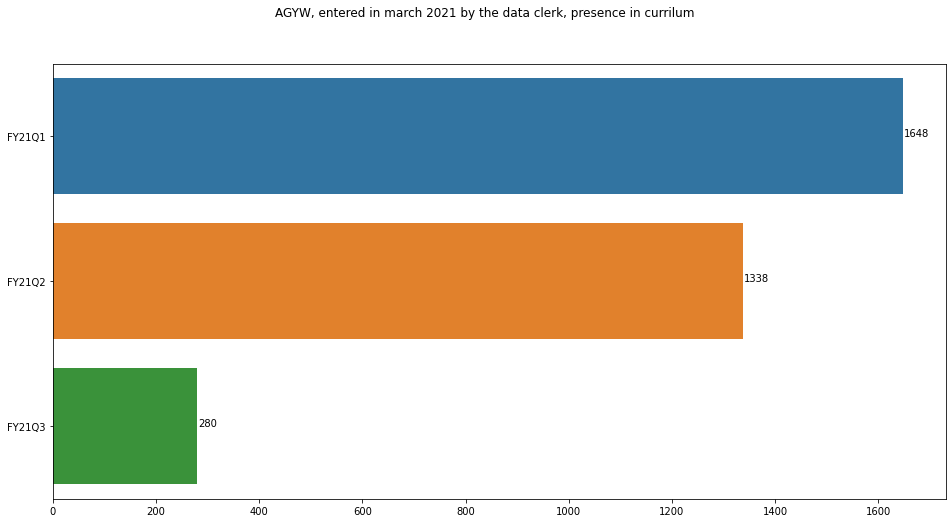

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pivot_epa = epa_fy21.pivot_table(columns="fiscal_year",values="patient_code",fill_value=0,aggfunc='count')

X= list(pivot_epa.columns)
Y= pivot_epa.values.tolist()[0]
data = []
colonnes = []

for x,y in zip(X,Y):
    data.append(y)
    colonnes.append(x)


df = pd.DataFrame({"fy":colonnes, "dt":data})

plt.subplots(figsize=(16,8))
splot = sns.barplot(x="dt",y="fy",data=df)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("AGYW, entered in march 2021 by the data clerk, presence in currilum")
for p in splot.patches:
    width = p.get_width()
    plt.text(2+p.get_width(), p.get_y()+0.50*p.get_height(),
             '{:1.0f}'.format(width))

plt.savefig("curriculum_Presence",dpi=400)

(<Figure size 1152x576 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'AGYW, entered in march 2021 by the data clerk, presence in currilum')

Text(1650.0, 0.0, '1648')

Text(1340.0, 1.0, '1338')

Text(282.0, 2.0, '280')

Text(1897.0, 3.0, '1895')

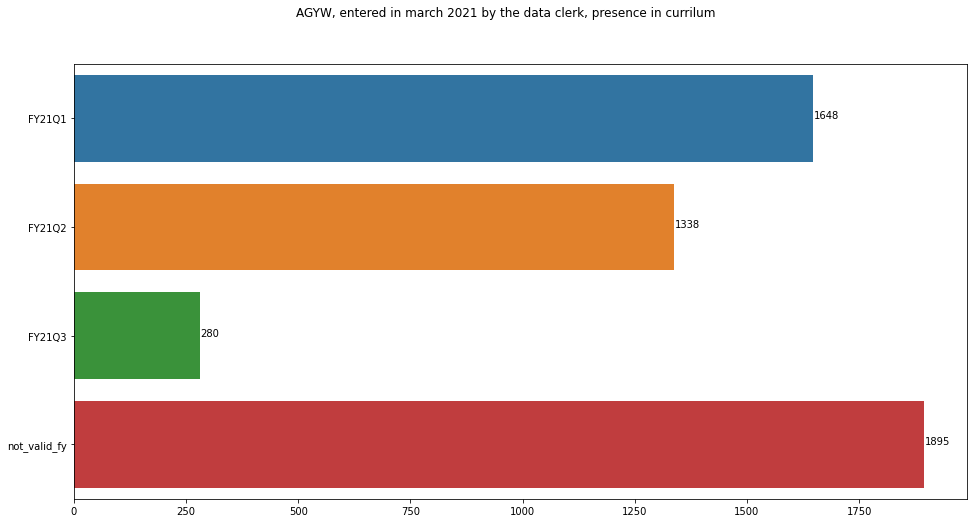

In [40]:
pivot_all_epa = all_epa.pivot_table(columns="fiscal_year",values="patient_code",fill_value=0,aggfunc='count')

X= list(pivot_all_epa.columns)
Y= pivot_all_epa.values.tolist()[0]
data = []
colonnes = []

for x,y in zip(X,Y):
    data.append(y)
    colonnes.append(x)


df = pd.DataFrame({"fy":colonnes, "dt":data})

plt.subplots(figsize=(16,8))
splot = sns.barplot(x="dt",y="fy",data=df)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("AGYW, entered in march 2021 by the data clerk, presence in currilum")
for p in splot.patches:
    width = p.get_width()
    plt.text(2+p.get_width(), p.get_y()+0.50*p.get_height(),
             '{:1.0f}'.format(width))

plt.savefig("curriculum_all_fiscal",dpi=400)